# Geiger2012CVPR

> Module to handle loading, preprocessing and postprocessing of the data from [Are we ready for Autonomous Driving? 
The KITTI Vision Benchmark Suite](https://www.cvlibs.net/publications/Geiger2012CVPR.pdf).

> Based on the [Bird's Eye View Evaluation 2017](https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=bev).

> The main purpose of this work is to serve as the information used for training the 2nd stage of the [MVLidarNet: Real-Time Multi-Class Scene Understanding for Autonomous Driving Using Multiple Views](https://arxiv.org/pdf/2006.05518) model.

In [1]:
#| default_exp Geiger2012CVPR 

In [2]:
#| export
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import yaml
from pathlib import Path
import numpy as np
from lightning import LightningDataModule
from torchvision.transforms import v2

In [3]:
#| export
class ObjectKITTIDataset(Dataset):
    "load the objectKITTI data in a pytorch Dataset object."
    def __init__(self, data_path, is_train=True, transform=None):
        data_path = Path(data_path)
        self.object_velodyne_path = data_path/'data_object_velodyne'
        self.object_labels_path = data_path/'data_object_label_2'

        object_velodyne_fns = []
        if is_train:
            query = '*training/velodyne/*.bin'
            object_velodyne_fns += list(self.object_velodyne_path.rglob(query))
            self.instance = 'training'
        else:
            query = '*testing/velodyne/*.bin'
            object_velodyne_fns += list(self.object_velodyne_path.rglob(query))
            self.instance = 'testing'
            
        self.object_frame_ids = [fn.stem for fn in object_velodyne_fns]
        self.transform = transform
        self.is_train = is_train
    

    def set_transform(self, transform):
        self.transform = transform
        
    def __len__(self):
        return len(self.object_frame_ids)

    def __getitem__(self, idx):
        object_frame_id = self.object_frame_ids[idx]
        object_frame_instance = self.instance
        
        object_frame_path = self.object_velodyne_path/object_frame_instance/'velodyne'/(object_frame_id + '.bin')
        with open(object_frame_path, 'rb') as f:
            object_frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

        labels = None
        if self.is_train:
            label_path = self.object_labels_path/(object_frame_id + '.txt')
            with open(label_path, 'r') as f:
                values = [line.strip().split() for line in f]

            objects = []
            for line in range(len(values)):
                label = values[line][0]
                truncation = float(values[line][1])
                occlusion = int(values[line][2])
                alpha = float(values[line][3])

                bb_2D_x1 = float(values[line][4])
                bb_2D_y1 = float(values[line][5])
                bb_2D_x2 = float(values[line][6])
                bb_2D_y2 = float(values[line][7])

                bb_3D_height = float(values[line][8])
                bb_3D_width = float(values[line][9])
                bb_3D_length = float(values[line][10])
                bb_3D_xyz = [float(values[line][11]), float(values[line][12]), float(values[line][13])]
                bb_3D_ry = float(values[line][14])

                dict = {
                    'label': label,
                    'truncation': truncation,
                    'occlusion': occlusion,
                    'alpha': alpha,
                    'bb_2D_x1': bb_2D_x1,
                    'bb_2D_y1': bb_2D_y1,
                    'bb_2D_x2': bb_2D_x2,
                    'ybb_2D_y2': bb_2D_y2,
                    'bb_3D_height': bb_3D_height,
                    'bb_3D_width': bb_3D_width,
                    'bb_3D_length': bb_3D_length,
                    'bb_3D_xyz': bb_3D_xyz,
                    'bb_3D_ry': bb_3D_ry
                }
                objects.append(dict)
            
            labels = objects

        #TODO: Visualization
        return object_frame, labels
        

To use it, first download and extract the *data_object_velodyne* and *dataobject_label_2* folders from the provided links on their [Bird's Eye View Evaluation 2017](https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=bev) website (velodyne point clouds 29 GB and training labels of object data set 5 MB) into a folder at the root of your workspace. Then, use the following code to get the training data in its original format:

In [4]:
#| eval: false
data_path = 'workspace/root'
ds = ObjectKITTIDataset(data_path)
frame, label = ds[143]

Without any transform set, the data is simply read into numpy arrays.

In [5]:
#| eval: false
frame, frame.shape, label

(array([[ 26.459,   6.132,   1.128,   0.99 ],
        [ 26.44 ,   6.215,   1.128,   0.99 ],
        [ 26.415,   6.297,   1.127,   0.99 ],
        ...,
        [ 26.161,  -5.578, -12.357,   0.   ],
        [ 26.134,  -5.486, -12.335,   0.   ],
        [ 26.137,  -5.401, -12.329,   0.   ]], dtype=float32),
 (120972, 4),
 [{'label': 'Truck',
   'truncation': 0.0,
   'occlusion': 0,
   'alpha': -1.57,
   'bb_2D_x1': 588.19,
   'bb_2D_y1': 166.53,
   'bb_2D_x2': 615.61,
   'ybb_2D_y2': 196.24,
   'bb_3D_height': 2.85,
   'bb_3D_width': 2.63,
   'bb_3D_length': 12.34,
   'bb_3D_xyz': [-0.88, 2.32, 76.16],
   'bb_3D_ry': -1.59},
  {'label': 'Car',
   'truncation': 0.0,
   'occlusion': 1,
   'alpha': 2.21,
   'bb_2D_x1': 4.58,
   'bb_2D_y1': 199.18,
   'bb_2D_x2': 128.63,
   'ybb_2D_y2': 248.05,
   'bb_3D_height': 1.49,
   'bb_3D_width': 1.81,
   'bb_3D_length': 3.36,
   'bb_3D_xyz': [-18.95, 2.47, 25.29],
   'bb_3D_ry': 1.57},
  {'label': 'Car',
   'truncation': 0.0,
   'occlusion': 1,
   'al

## Lidar Bird's Eye View Projections

Alongside range image projections, Bird's Eye View (BEV) projections are also one of the most efficient and performant ways to process Lidar point clouds. 

The idea behind this method is to simulate a top-down perspective of the 3D Lidar point cloud in order to provide a comprehensive overview of an area, making it easier to understand spatial relationships and layouts in a 2D format. In this work, the BEV algorithm and explanations are inspired by [Ronny Restrepo's](http://ronny.rest/tutorials/module/pointclouds_01/point_cloud_birdseye/) BEV tutorial.

In [6]:
#| export
class BEVProjection:
    def __init__(self, res=0.2, side_range=(-102.3, 102.3), fwd_range=(-102.3, 102.3), height_range=(-2, 2) ):
        self.res = res
        self.side_range = side_range
        self.fwd_range = fwd_range
        self.height_range = height_range

    def scale_to_255(self, pixel_values, min, max, dtype=np.uint8):
        return (((pixel_values - min) / float(max - min)) * 255).astype(dtype)

    def get_BEV_projection(self, point_cloud, label=False):
        x_coord = point_cloud[:, 0]
        y_coord = point_cloud[:, 1]
        z_coord = point_cloud[:, 2]
        intensity = point_cloud[:, 3]
        
        # Three filters for idx points: Front-to-back, side-to-side, and height ranges
        f2b_filter = np.logical_and((x_coord > self.fwd_range[0]), (x_coord < self.fwd_range[1]))
        s2s_filter = np.logical_and((y_coord > -self.side_range[1]), (y_coord < -self.side_range[0]))
        filter = np.logical_and(f2b_filter, s2s_filter)
        idx = np.argwhere(filter).flatten()

        x_coord = x_coord[idx]
        y_coord = y_coord[idx]
        z_coord = z_coord[idx]
        intensity = intensity[idx]

        # Pixel positions based on resolution
        x_bev = (-y_coord / self.res).astype(np.int32)
        y_bev = (-x_coord / self.res).astype(np.int32)

        # Minimum (0,0) after shift
        x_bev -= int(np.floor(self.side_range[0] / self.res))
        y_bev += int(np.ceil(self.fwd_range[1] / self.res))

        x_bev_max = 2 + int((self.side_range[1] - self.side_range[0]) / self.res)
        y_bev_max = 2 + int((self.fwd_range[1] - self.fwd_range[0]) / self.res)

        if label:
            pixel_values = point_cloud[:, 3:][idx]
            bev_img = np.zeros([y_bev_max, x_bev_max, 3], dtype=np.uint8)
            bev_img[y_bev, x_bev] = pixel_values
        else:
            bev_img_min = np.full((y_bev_max, x_bev_max), np.inf, dtype=np.float32)
            bev_img_max = np.full((y_bev_max, x_bev_max), self.height_range[0], dtype=np.float32)
            bev_img_mean_intensity = np.zeros((y_bev_max, x_bev_max), dtype=np.float32)
            count = np.zeros((y_bev_max, x_bev_max), dtype=np.int32)

            for i in range(len(x_bev)):
                y, x = y_bev[i], x_bev[i]
                z, intensity_val = z_coord[i], intensity[i]

                if z < bev_img_min[y, x]:
                    bev_img_min[y, x] = z

                if z > bev_img_max[y, x]:
                    bev_img_max[y, x] = z

                bev_img_mean_intensity[y, x] += intensity_val
                count[y, x] += 1

            count = np.maximum(count, 1)
            bev_img_mean_intensity /= count

            bev_img_min[bev_img_min == np.inf] = 0
            bev_img_min = self.scale_to_255(bev_img_min, self.height_range[0], self.height_range[1])
            bev_img_max = self.scale_to_255(bev_img_max, self.height_range[0], self.height_range[1])
            bev_img_mean_intensity = self.scale_to_255(bev_img_mean_intensity, np.min(intensity), np.max(intensity))

            bev_img = np.stack((bev_img_min, bev_img_max, bev_img_mean_intensity), axis=-1)

        return bev_img
        

In this implementation of a BEV projection, the relevant axes from the point cloud data will be the x and y axes. That being said, there is some things that have to be taken in consideration:
- The x and y axes have opposite meanings, that is, x will be the forward range and y the side range.
- The x and y axes point in the opposite direction.
- There is the need to shift the values of the pixels so that (0,0) is the smallest possible value in the projection.

The following image from [Ronny Restrepo's](http://ronny.rest/tutorials/module/pointclouds_01/point_cloud_birdseye/) BEV implementation illustrates what was said before:

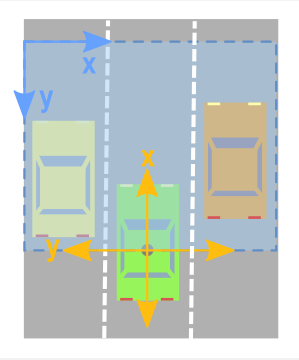

In case you're wondering, the values for `res`, `side_range`, `fwd_range` and `height_range` are totally changeble based on your problem, but in the case of this work, it has those values so that the final shape of our BEV projection used for training is (1024, 1024, 3) wihtout losing points in the process. Also, it is taken in consideration the min, max, and mean height data in which are important for this work. A quick test example is as follows:

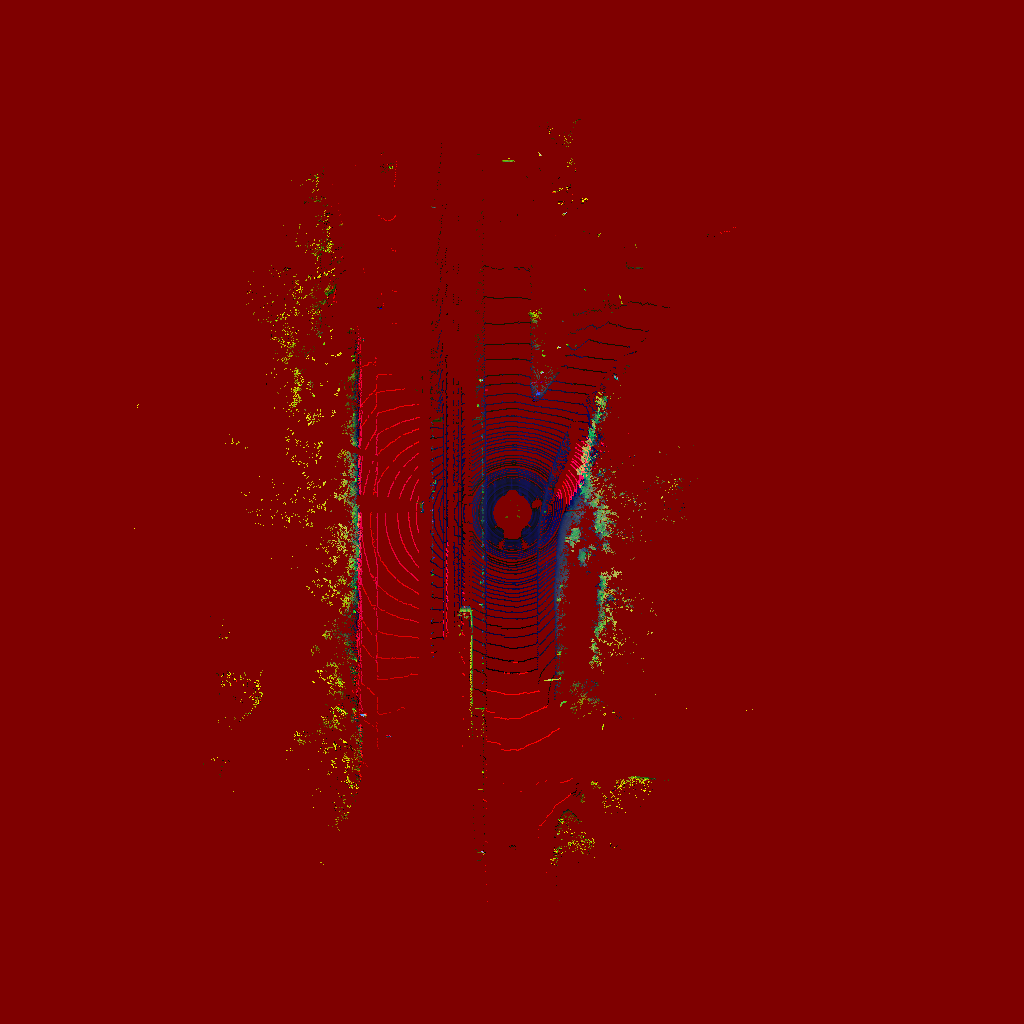

In [7]:
#| eval: False
bev_proj = BEVProjection()
bev_image = bev_proj.get_BEV_projection(frame)
bev_image = Image.fromarray(bev_image)
bev_image

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()